# Milestone 3 - the daTaBABES

This notebook contains our analysis of the data contained in the beer datasets from two websites BeerAdvocate (BA) and RateBeer (RB). The goal of this analysis is to answer the following question:  
**What would be the ideal beer for the US consumer depending on the month?**


In [1]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import re
import spacy
from collections import Counter

import json

from scipy.stats import f_oneway
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as st
import math

import hashlib

import requests
import statsmodels.formula.api as smf
import networkx as nx


In [2]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

Users have rated the beers from two websites, RateBeer and BeerAdvocate, thus we get reviews of users from two distinct datasets. The reviews are in txt files, thus we convert the txt files into csv so that we can manipulate the data more easily. By doing this, we get as much as data as we can.

The conversion of the txt files into csv files is done in the notebook 'preprocessing_txt.ipynb'.

# Preprocessing

## Loading the datasets

In [3]:
# Loading the ratings datasets 
ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')
ratings_matched_df = pd.read_csv('data/matched_beer_data/ratings.csv')

# Loading the users dataset 
users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')
users_matched_df = pd.read_csv('data/matched_beer_data/users.csv')

# Loading the beers dataset
beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')
beers_matched_df = pd.read_csv('data/matched_beer_data/beers.csv')

breweries_ba_df = pd.read_csv('data/BeerAdvocate/breweries.csv')
breweries_rb_df = pd.read_csv('data/RateBeer/breweries.csv')

In [4]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

In [5]:
# Create a year_month column
ratings_ba_df['year_month'] = ratings_ba_df['year'].astype(str) + '-' + ratings_ba_df['month'].astype(str)
ratings_rb_df['year_month'] = ratings_rb_df['year'].astype(str) + '-' + ratings_rb_df['month'].astype(str)

# Convert the year_month column to datetime format
ratings_ba_df['year_month'] = pd.to_datetime(ratings_ba_df['year_month'])
ratings_rb_df['year_month'] = pd.to_datetime(ratings_rb_df['year_month'])


In [6]:
# Create copy of original datasets
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()
beers_ba_df_untouched = beers_ba_df.copy()
beers_rb_df_untouched = beers_rb_df.copy()

In [7]:
# Print the number of ratings in each dataset
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2715712
Number of ratings in RateBeer: 7122074


Names of brewery id don't match for both datasets:

In [8]:
beers_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,scores,scores.1
0,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id,brewery_name,nbr_matched_valid_ratings,nbr_ratings,overall_score,style,style_score,zscore,diff,sim
1,4.8,3.45,3.439866666666666,3.504067796610169,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.69830388113311,1.0,1.0


Names of beer styles don't match for both datasets:

In [9]:
ratings_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.6,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,rb.15
0,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel


## Is the beer_id really unique ? 

By having two different datasets, we have numerous problems that could impact our analysis: 
* Do we have similar *beer_id* in the two datasets but do not represent the same beer ?
* Do we have similar *brewery_id* in the two datasets but do not represent the same beer ? 

1. Are beers really unique ? 

In [10]:
beers_ba = beers_ba_df.beer_id.unique()
beers_rb = beers_rb_df.beer_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.beer_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.beer_id == beer_id])

Number of unique beers in BeerAdvocate: 280823
Number of unique beers in RateBeer: 442081
Number of beers in both datasets: 220120
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
269762,3,Cactus Queen IPA,2,Yellow Rose Brewing Company,American IPA,3,3,4.11,NaN,90.0,NaN,4.106667,NaN,0,NaN


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
160124,3,Abita Andygator,1,Abita Brewing Company,Doppelbock,682,31.0,17.0,2.95,8.0,2.950293,-0.703049,682,2.950293


We observe that eventhough there are exactly 220,120 beers that have the same *beer_id* between the two datasets. If we observe one of the beer_id that appears in the same datasets, the description of the beer is not the same. This could impact our future analysis, since the analysis of the ratings would be biased. 

2. Are breweries really unique ? 

In [11]:
breweries_ba = breweries_ba_df.id.unique()
breweries_rb = breweries_rb_df.id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.id == brewery_id])


Number of unique breweries in BeerAdvocate: 16758
Number of unique breweries in RateBeer: 24189
Number of breweries in both datasets: 7094
BeerAdvocate:


,id,location,name,nbr_beers
6880,1,Czech Republic,Plzeňský Prazdroj,24


RateBeer:


,id,location,name,nbr_beers
13443,1,"United States, Louisiana",Abita Brewing Company,127


We can observe the same problem for the breweries. 

A first approach is to generate a new *id* with the informations of the beers. With *hashlib*, if the same information are used to compute the id in both datasets, it will be immediate to match the same beers. But, first we need to select the informations that will be used to compute the new *id* of the beer. 

Let's see in the matched dataset if the beers matched have exactly the same informations. 

3. Do the same beers have the same description in both datasets ? 

In [12]:
print('Number of ratings in the matched dataset: {}'.format(ratings_matched_df.shape[0]))

Number of ratings in the matched dataset: 21965


In [13]:
ratings_matched_df_ba = ratings_matched_df[['ba', 'ba.1', 'ba.2', 'ba.3', 'ba.4', 'ba.5', 'ba.6', 'ba.7', 'ba.8',
       'ba.9', 'ba.10', 'ba.11', 'ba.12', 'ba.13', 'ba.14', 'ba.15', 'ba.16']]

ratings_matched_df_rb = ratings_matched_df[['rb', 'rb.1', 'rb.2', 'rb.3', 'rb.4', 'rb.5', 'rb.6', 'rb.7', 'rb.8',
         'rb.9', 'rb.10', 'rb.11', 'rb.12', 'rb.13', 'rb.14', 'rb.15']]

In [14]:
# consider as the header the first row of the dataframe and drop it
ratings_matched_df_ba.columns = ratings_matched_df_ba.iloc[0]
ratings_matched_df_ba = ratings_matched_df_ba.drop(ratings_matched_df_ba.index[0])

ratings_matched_df_rb.columns = ratings_matched_df_rb.iloc[0]
ratings_matched_df_rb = ratings_matched_df_rb.drop(ratings_matched_df_rb.index[0])

In [15]:
ratings_matched_df_ba.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
2,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,3.0,True,American Adjunct Lager,NaN,NaN,visionthing.639993,visionthing


In [16]:
ratings_matched_df_rb.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.0,10.0,2360,Rochefort Trappistes 10,406,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
2,5.0,2.0,3.0,17109,Myanmar Lager Beer,2921,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


**Problems**: 
* We can generate a new *id* in both datasets for the beer with the unique attributes such as abv, beer_name and style. But, as observed above, the problem is that the style and even the beer_name does not appear the same in both datasets. Thus, we could not match the same beers when merging the two datasets. They will be considered as different beers. 
* We cannot use the matched dataset to match every beer, since the dataset only contains ratings given by same user to the same beer. 

**Solution**: 

We decide to compute a new *id* for each beer and a new *id* for each brewery as well. To do so, we use the *hashlib* function. 
* For **beer_id** : we use style, name and abv to compute the new *id*.
* For **brewery_id**: we use the name and location to compute the new *id*.

In [17]:
def generate_unique_id_beer(name, brewery_name, style, abv):
    unique_id = hashlib.sha256(f"{name}{brewery_name}{style}{abv}".encode()).hexdigest()
    return unique_id

def generate_unique_id_brewery(name, country):
    unique_id = hashlib.sha256(f"{name}{country}".encode()).hexdigest()
    return unique_id

# Create a unique id for each beer in the BeerAdvocate dataset
beers_ba_df['new_id'] = beers_ba_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)
beers_rb_df['new_id'] = beers_rb_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)

# Create a unique id for each brewery in the BeerAdvocate dataset
breweries_ba_df['new_id'] = breweries_ba_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)
breweries_rb_df['new_id'] = breweries_rb_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)

# create new_id_beer and new_id_brewery columns in the ratings datasets 
ratings_ba_df['new_id_beer'] = ratings_ba_df['beer_id'].map(beers_ba_df.set_index('beer_id')['new_id'])
ratings_rb_df['new_id_beer'] = ratings_rb_df['beer_id'].map(beers_rb_df.set_index('beer_id')['new_id'])

In [18]:
ratings_ba_df['new_id_brewery'] = ratings_ba_df['brewery_id'].map(breweries_ba_df.set_index('id')['new_id'])
ratings_rb_df['new_id_brewery'] = ratings_rb_df['brewery_id'].map(breweries_rb_df.set_index('id')['new_id'])

Let's verify now if we have intersected beer_ids. 

In [19]:
beers_ba = beers_ba_df.new_id.unique()
beers_rb = beers_rb_df.new_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == beer_id])

Number of unique beers in BeerAdvocate: 280340
Number of unique beers in RateBeer: 441961
Number of beers in both datasets: 318
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
59034,22191,Texels Skuumkoppe,526,Texelse Bierbrouwerij,Dunkelweizen,63,21,3.66,83.0,NaN,6.0,3.593651,-0.620733,24,3.582917,00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
122954,23569,Texels Skuumkoppe,1995,Texelse Bierbrouwerij,Dunkelweizen,264,44.0,64.0,3.12,6.0,3.138636,-0.429225,264,3.138636,00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...


We observe here that the sample of beers in both dataset has reduced a lot. We still have 922 beers that are contained into both. If we print the description of the beers, we see that they are exactly the same. This solves our previous problem. 

Let's verify the same for brewery_id.

In [20]:
breweries_ba = breweries_ba_df.new_id.unique()
breweries_rb = breweries_rb_df.new_id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == brewery_id])

Number of unique breweries in BeerAdvocate: 16443
Number of unique breweries in RateBeer: 24185
Number of breweries in both datasets: 5912
BeerAdvocate:


,id,location,name,nbr_beers,new_id
9385,41055,"United States, Washington",Cascadia Homebrew,4,00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...


RateBeer:


,id,location,name,nbr_beers,new_id
14431,25842,"United States, Washington",Cascadia Homebrew,6,00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...


## US consumers 

To start our analysis, we look at the distribution of unique users across different countries. We would like to focus on a single country for our analysis as ratings from users from different regions can introduce mixed results that represents no country in reality. For example a certain type of beer can be appreciated in summer and not in winter. But depending on the region of the worls, summer and winter are in different time of the year. So looking at the rating of that beer for each month for each users will not showcase this particularity. By narrowing down to one country, we get a clearer picture of what people in that specific place like. This helps us avoid getting mixed results that might be affected by different tastes and seasons in different parts of the world.

In [21]:
# Extract the country from the location
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

In [22]:
# Number of users per country, in RateBeer
rb_user_count_country = users_rb_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in RateBeer')

# Number of users per country, in BeerAdvocate
ba_user_count_country = users_ba_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in BeerAdvocate')

In [23]:
# Merge the two above data frames to count the total number of users per country
users_country = rb_user_count_country.merge(ba_user_count_country, on='location')
users_country['total nb of users'] = users_country['nb users in RateBeer'] + users_country['nb users in BeerAdvocate']
users_country = users_country.sort_values('total nb of users', ascending=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'England'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Poland'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Germany'),
  Text(8, 0, 'Belgium'),
  Text(9, 0, 'Denmark')])

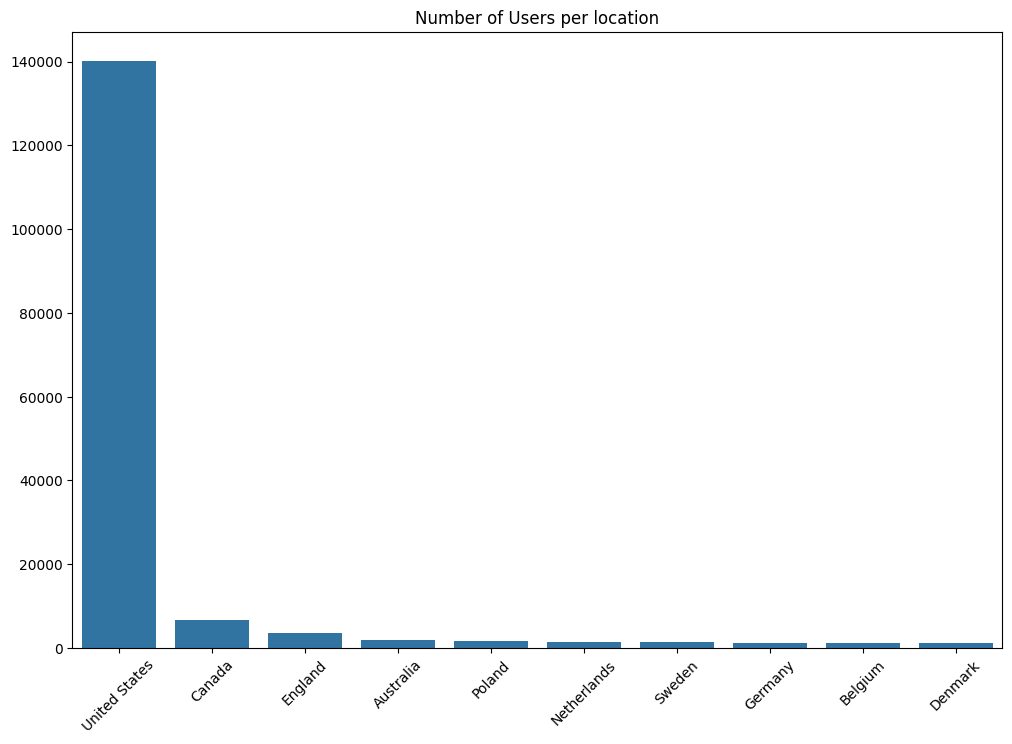

In [24]:
# Plot the distribution of the number of users per country
plt.figure(figsize=(12,8))
sns.barplot(x=users_country['location'].values[:10], y=users_country['total nb of users'].values[:10])
plt.title('Number of Users per location')
plt.xticks(rotation=45)

As we see, the US has much more users than the other countries. This leads us to think that by focusing on this country, we will get the most diverse reviews as they come from many different users. If we would consider Canada for example, we could have bias results as there are not so many users and the reviews come from a small set of people, leading us to provide a perfect beer for very few people. For this reason, our analysis will be focused on the US only.

In [25]:
US_country = 'United States'

# Keep only the rows where the user country is United States
users_ba_df_us = users_ba_df[users_ba_df.location == US_country]
users_rb_df_us = users_rb_df[users_rb_df.location == US_country]

# Keep only the rows where the user country is not from United States
users_ba_df_ca = users_ba_df[users_ba_df.location != US_country]
users_rb_df_ca = users_rb_df[users_rb_df.location != US_country]

In [26]:
# Merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df_us = pd.merge(ratings_ba_df, users_ba_df_us[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_us = pd.merge(ratings_rb_df, users_rb_df_us[['user_id', 'location']], on='user_id', how='inner')

ratings_users_ba_df_ca = pd.merge(ratings_ba_df, users_ba_df_ca[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_ca = pd.merge(ratings_rb_df, users_rb_df_ca[['user_id', 'location']], on='user_id', how='inner')

Filtered dataframe to separate ratings from US users from the rest

In [27]:
# filter the ratings dataframes to only keep ratings of the users from the US
ratings_ba_df_us = ratings_users_ba_df_us[ratings_users_ba_df_us.location == US_country]
ratings_ba_df_us.drop('location', axis=1, inplace=True)
ratings_rb_df_us = ratings_users_rb_df_us[ratings_users_rb_df_us.location == US_country]
ratings_rb_df_us.drop('location', axis=1, inplace=True)

# filter the ratings dataframes to only keep ratings of the users not from US
ratings_ba_df_ca = ratings_users_ba_df_ca[ratings_users_ba_df_ca.location != US_country]
ratings_ba_df_ca.drop('location', axis=1, inplace=True)
ratings_rb_df_ca = ratings_users_rb_df_ca[ratings_users_rb_df_ca.location != US_country]
ratings_rb_df_ca.drop('location', axis=1, inplace=True)


Number of ratings from the US in BeerAdvocate: 2346494
Number of ratings from the US in Ratebeer: 3108958
Number of ratings not from US in BeerAdvocate: 369218
Number of ratings not from US in Ratebeer: 4014825


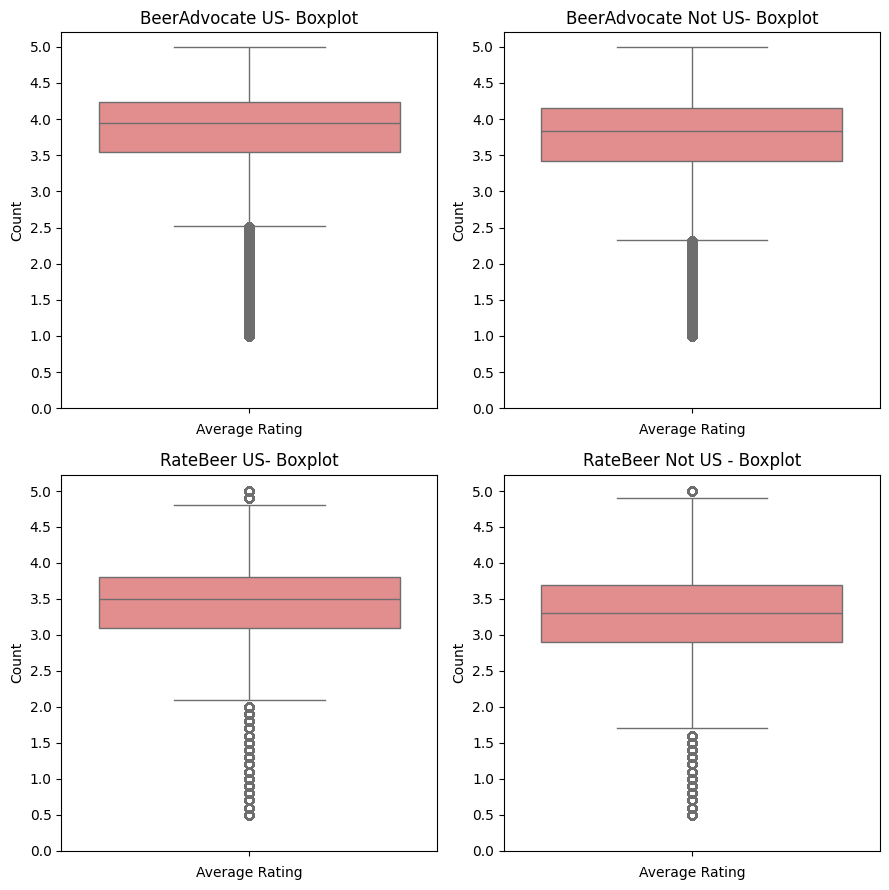

In [28]:
# Plot the distribution of the number of ratings per user
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of ratings from the US in BeerAdvocate:", len(ratings_ba_df_us))
print("Number of ratings from the US in Ratebeer:", len(ratings_rb_df_us))
print("Number of ratings not from US in BeerAdvocate:", len(ratings_ba_df_ca))
print("Number of ratings not from US in Ratebeer:", len(ratings_rb_df_ca))

# BeerAdvocate US- Boxplot
sns.boxplot(ratings_ba_df_us['rating'], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('BeerAdvocate US- Boxplot')
axes[0, 0].set_yticks(np.arange(0, 5.5, 0.5))

# BeerAdvocate Not US- Boxplot
sns.boxplot(ratings_ba_df_ca['rating'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('BeerAdvocate Not US- Boxplot')
axes[0, 1].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer US- Boxplot
sns.boxplot(ratings_rb_df_us['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('RateBeer US- Boxplot')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer Not US - Boxplot
sns.boxplot(ratings_rb_df_ca['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('RateBeer Not US - Boxplot')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

### Mann-Whithney U Test
* US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between the US and non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between the US and non-US beers.
* US vs US:
    - Null Hypothesis (H0): There is no difference in beer ratings between US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between US beers.
* Not US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between non-US beers.

In [29]:
# test if the ratings from the US and not from the US are from the same distribution
print('BeerAdvocate:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_ca['rating'], ratings_ba_df_ca['rating']))

print('RateBeer:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_ca['rating'], ratings_rb_df_ca['rating']))


BeerAdvocate:
US vs Not US


MannwhitneyuResult(statistic=481028997358.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=2753017046018.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=68160965762.0, pvalue=1.0)
RateBeer:
US vs Not US
MannwhitneyuResult(statistic=7274970199334.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=4832809922882.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=8059409890312.5, pvalue=1.0)


From the boxplot, we observe visually small differences in the distribution of the ratings between US users and non-US users. After the Mann-Whitney U Test, we significantly reject the null hypothesis for US vs Not US users, which means that the distributions are significantly different. Thus, we can focus uniquely on US users to avoid any bias in our analysis. 

Filter the datasets to only keep users from the US:

In [30]:
ratings_ba_df = ratings_ba_df_us
ratings_rb_df = ratings_rb_df_us

In [31]:
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2346494
Number of ratings in RateBeer: 3108958


## Are there users who excessively rate a beer in a short time period ?

Motivation: we want to handle the cases where we could have many ratings from a specific user for the same beer as it could be a user that is trying to bias the rating of a particular beer

In [32]:
# Assuming ratings_combined_df is your DataFrame
threshold = 3  # Adjust this threshold based on your criteria

# Group by user_id, beer_id, and year_month, and count the number of ratings
user_beer_counts_ba = ratings_ba_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')
user_beer_counts_rb = ratings_rb_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')

# Filter for instances where the rating count exceeds the threshold
excessive_ratings_ba = user_beer_counts_ba[user_beer_counts_ba['rating_count'] > threshold]
excessive_ratings_rb = user_beer_counts_rb[user_beer_counts_rb['rating_count'] > threshold]

print("Excessive ratings for BeerAdvocate:")
print(excessive_ratings_ba)
print("Excessive ratings for RateBeer:")
print(excessive_ratings_rb)

Excessive ratings for BeerAdvocate:
Empty DataFrame
Columns: [user_id, beer_id, year_month, rating_count]
Index: []
Excessive ratings for RateBeer:
         user_id  beer_id year_month  rating_count
184060      3070      252 2002-11-01             5
184061      3070      403 2002-01-01             5
184062      3070      411 2002-01-01             5
184063      3070      474 2002-01-01             5
184064      3070      707 2002-01-01             5
1474422    46797       46 2007-01-01            41
1474423    46797       86 2007-03-01            41
1474424    46797       87 2007-01-01            41
1474425    46797      145 2007-01-01            41
1474426    46797      589 2007-02-01            41
1474427    46797      594 2007-02-01            41
1474428    46797      662 2007-03-01            41
1474429    46797      663 2007-03-01            41
1474430    46797      690 2007-01-01            41
1474431    46797      714 2007-01-01            41
1474432    46797      745 2007-02-01

We decided to set the threshold to 3 as rating a same beer more than 3 times per month can seem suspicious. We have identified two users in RateBeer who rated the same beer excessively within a specific month. For example, user 46797 has rated 41 times many beers each month from december 2006 to march 2007.  
Such behavior is suspicious, and as a precautionary measure, we've decided to remove these users from the dataset to keep the reliability of the ratings.

In [33]:
# Remove the suspicious users
users_to_remove = [46797, 3070]
ratings_combined_df = ratings_ba_df[~ratings_ba_df['user_id'].isin(users_to_remove)]


## What is a popular beer ?

**Popularity definition:** By popular we mean with respect to the number of **good** reviews


#### Distribution of the average rating in BeerAdvocate

In [34]:
ratings_ba_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.346494e+06
mean,3.900441e+00,3.811440e+00,3.817201e+00,3.854748e+00,3.862540e+00,3.846907e+00
std,5.870042e-01,6.626348e-01,6.496978e-01,6.964354e-01,6.714755e-01,6.044712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.550000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.950000e+00
75%,4.250000e+00,4.250000e+00,4.250000e+00,4.500000e+00,4.250000e+00,4.240000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


#### Distribution of the average rating in RateBeer

In [35]:
ratings_rb_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06
mean,3.536766e+00,6.581593e+00,3.381866e+00,6.651427e+00,1.364188e+01,3.379354e+00
std,7.864937e-01,1.540261e+00,8.069702e-01,1.529019e+00,3.127803e+00,6.799184e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00,1.200000e+01,3.100000e+00
50%,4.000000e+00,7.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,3.500000e+00
75%,4.000000e+00,8.000000e+00,4.000000e+00,8.000000e+00,1.600000e+01,3.800000e+00
max,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01,2.000000e+01,5.000000e+00


Number of beers in BeerAdvocate: 2346494
Number of beers in RateBeer: 3108958


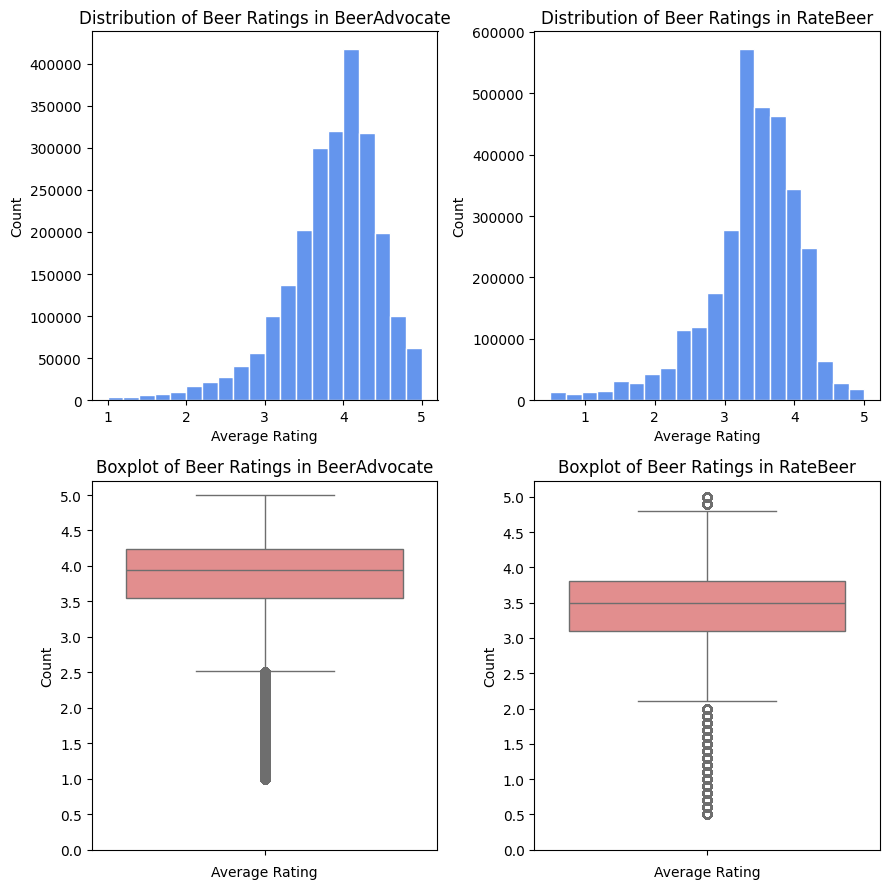

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of beers in BeerAdvocate:", len(ratings_ba_df))
print("Number of beers in RateBeer:", len(ratings_rb_df))

# BeerAdvocate - Histogram
axes[0, 0].hist(ratings_ba_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Beer Ratings in BeerAdvocate')

# RateBeer - Histogram
axes[0, 1].hist(ratings_rb_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Beer Ratings in RateBeer')
axes[0, 1].ticklabel_format(style="plain", axis="y")

# BeerAdvocate - Boxplot
sns.boxplot(ratings_ba_df['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Boxplot of Beer Ratings in BeerAdvocate')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer - Boxplot
sns.boxplot(ratings_rb_df['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Boxplot of Beer Ratings in RateBeer')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

In [37]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


### T-test on the ratings of the two datasets

Let's quantify the observed results with a t-test. 

In [38]:
t_statistic, p_value = st.ttest_ind(ratings_ba_df['rating'], ratings_rb_df['rating'])

# Output the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < 0.05:
    print("The ratings in the two datasets are statistically different.")
else:
    print("There is no significant difference in the ratings between the two datasets.")


T-Statistic: 833.6675344272143
P-Value: 0.0
The ratings in the two datasets are statistically different.


As observed from the tables and the plot above, even though the distributions have a similar shape, i.e. normal distribution, they have a different average mean ratings. Indeed, users from the RateBeer dataset seem to be harsher in their ratings.

Now, as defined above, our popularity definition concerns the number of good ratings. A question that arises is: what can be considered as a good rating?

The ratings are continuous numbers between 0 to 5. One idea is to keep the ratings above the average mean of the two datasets and consider them as good rating. With this, we take in account the different distribution of the ratings into the two datasets and find a relatively good threshold.

Let's see what are the 10 most rated beer styles in each dataset:

Number of Beer Styles in AdvocateBeer: 104
Number of Beer Styles in RateBeer: 90


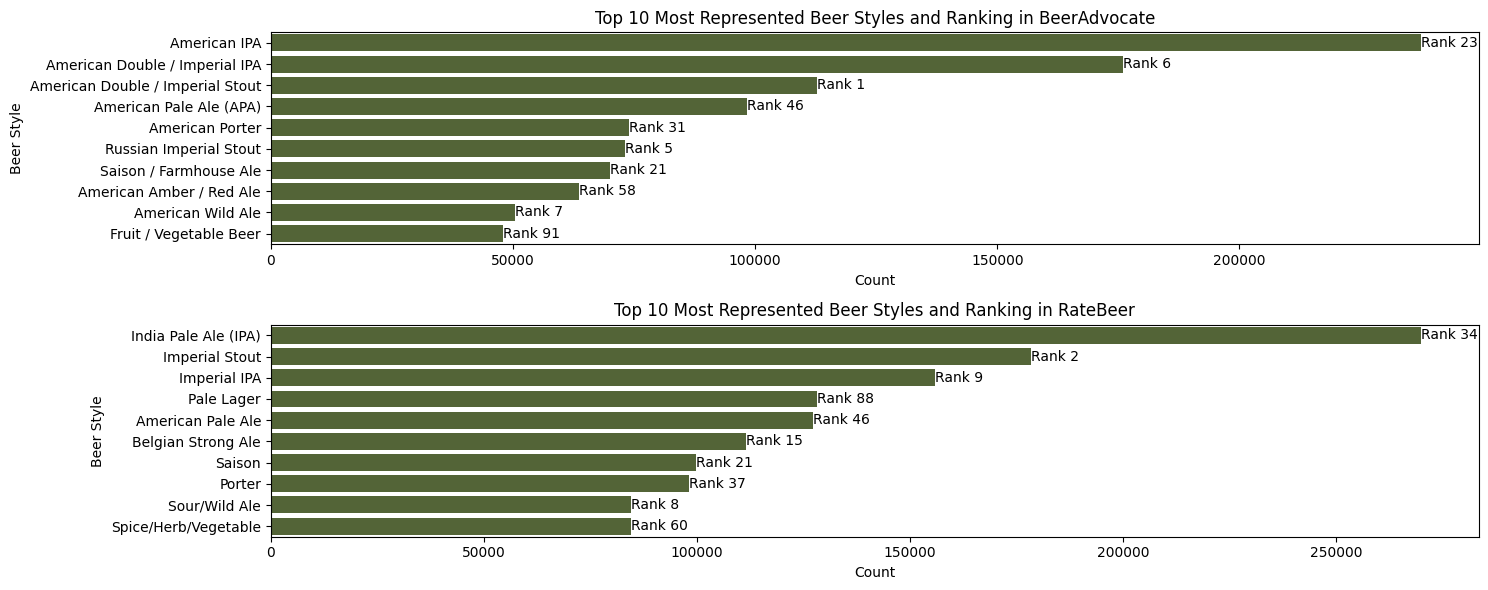

In [39]:
top_ratings_by_style_ba = ratings_ba_df.groupby('style')['rating'].mean().sort_values(ascending=False)
top_ratings_by_style_rb = ratings_rb_df.groupby('style')['rating'].mean().sort_values(ascending=False)

print(f"Number of Beer Styles in AdvocateBeer: {len(top_ratings_by_style_ba)}")
print(f"Number of Beer Styles in RateBeer: {len(top_ratings_by_style_rb)}")

# Number of top beer styles to plot
x = 10

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# BeerAdvocate
plot1 = sns.countplot(y='style', data=ratings_ba_df, order=ratings_ba_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[0])
for i, style in enumerate(ratings_ba_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_ba.index.get_loc(style) + 1  
    plot1.text(ratings_ba_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Beer Style')
axes[0].set_title(f'Top {x} Most Represented Beer Styles and Ranking in BeerAdvocate')

# RateBeer
plot2 = sns.countplot(y='style', data=ratings_rb_df, order=ratings_rb_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[1])
for i, style in enumerate(ratings_rb_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_rb.index.get_loc(style) + 1  
    plot2.text(ratings_rb_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Beer Style')
axes[1].set_title(f'Top {x} Most Represented Beer Styles and Ranking in RateBeer')

plt.tight_layout()
plt.show()

From the two plots above we can observe that a beer style can be popular but not have the best rating. For example in the plot of the RateBeer dataset, we see that the 3rd most popular beer style with respect to “count” is the 91th most popular beer style (over 93) when it comes to mean average rating.

## Final datasets to continue further analysis

To facilitate further analysis, we prepare a dataframe with the useful informations such as the location of the brewery and the volume of alcohol of the beer.

In [40]:
# verify if there are any duplicates in the beers dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', beers_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', beers_rb_df.duplicated(subset=['new_id']).sum())

duplicate_beers_ba = beers_ba_df[beers_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_beers_rb = beers_rb_df[beers_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_beer_ba = duplicate_beers_ba.iloc[0]
first_duplicate_beer_rb = duplicate_beers_rb.iloc[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == first_duplicate_beer_ba.new_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == first_duplicate_beer_rb.new_id])

Number of duplicates in BeerAdvocate: 483
Number of duplicates in RateBeer: 120
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
6105,139099,Amber Ale,33363,Fourpure Brewing Co.,American Amber / Red Ale,5,1,3.54,NaN,NaN,5.1,3.53,NaN,0,NaN,d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...
6123,165403,Amber Ale,37085,Fourpure Brewing Co.,American Amber / Red Ale,1,0,3.12,NaN,NaN,5.1,3.12,NaN,0,NaN,d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
3159,353940,Talón de Aquiles,24064,cerartmex,Porter,0,NaN,NaN,NaN,5.0,NaN,NaN,0,NaN,4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...
3160,353941,Talón de Aquiles,24064,cerartmex,Porter,0,NaN,NaN,NaN,5.0,NaN,NaN,0,NaN,4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...


In [41]:
# verify if there are any duplicates in the breweries dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', breweries_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', breweries_rb_df.duplicated(subset=['new_id']).sum())

duplicate_breweries_ba = breweries_ba_df[breweries_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_breweries_rb = breweries_rb_df[breweries_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_brewery_ba = duplicate_breweries_ba.iloc[0]
first_duplicate_brewery_rb = duplicate_breweries_rb.iloc[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == first_duplicate_brewery_ba.new_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == first_duplicate_brewery_rb.new_id])

Number of duplicates in BeerAdvocate: 315
Number of duplicates in RateBeer: 4
BeerAdvocate:


,id,location,name,nbr_beers,new_id
68,34598,Wales,Rhymney Brewery,2,c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...
69,12936,Wales,Rhymney Brewery,13,c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...


RateBeer:


,id,location,name,nbr_beers,new_id
1437,23620,Canada,Ridge Brewing Company,15,d1654b815d4c4fe51e802b37bd71993613aef646d6df63...
1491,3317,Canada,Ridge Brewing Company,12,d1654b815d4c4fe51e802b37bd71993613aef646d6df63...


We observe that the same beer appears multiple times in the dataset of beers description and breweries description in BeerAdvocate and RateBeer. Let's drop those duplicates. 

In [42]:
# drop the duplicates
beers_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
beers_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

breweries_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
breweries_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

In [43]:
# add column abv to the ratings datasets
ratings_ba_df['abv'] = ratings_ba_df['new_id_beer'].map(beers_ba_df.set_index('new_id')['abv'])
ratings_rb_df['abv'] = ratings_rb_df['new_id_beer'].map(beers_rb_df.set_index('new_id')['abv'])

# add column brewery_location to the ratings datasets
ratings_ba_df['brewery_location'] = ratings_ba_df['new_id_brewery'].map(breweries_ba_df.set_index('new_id')['location'])
ratings_rb_df['brewery_location'] = ratings_rb_df['new_id_brewery'].map(breweries_rb_df.set_index('new_id')['location'])

# Add column 'dataset' to the datasets to know where each row comes from orignally 
ratings_ba_df['dataset'] = 'BeerAdvocate'
ratings_rb_df['dataset'] = 'RateBeer'

# merge the two ratings dataframes
ratings_combined_df_untouched = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# Temporal Analysis

## General Analysis

In [44]:
def dataframe_time_analysis(df, year_lower, year_upper):
    # create a year_month column
    ratings_combined_df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

    # convert the year_month column to datetime format
    ratings_combined_df['year_month'] = pd.to_datetime(ratings_combined_df['year_month'])

    # group by year_month and count the number of ratings per year_month
    year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()
    
    # creating a new dataframe with the number of ratings per year_month
    year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

    # create column year and month
    year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
    year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

    # keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= year_lower) & (year_month_ratings_count_df.year < year_upper)]

    # compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    return year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month 

In [45]:
year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_combined_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings. 

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [46]:
# Create a new dataframe with the number of ratings per year_month
year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

# Create column year and month
year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

# Keep only rows where the year is greater than 2011 and less than 2017 
year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= 2008) & (year_month_ratings_count_df.year < 2017)]

# Compute the mean number of ratings per month
mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

# Plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings.

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [47]:
average_ratings_ba_df = ratings_ba_df.rating.mean()
average_ratings_rb_df = ratings_rb_df.rating.mean()

print('Average rating for BeerAdvocate:', average_ratings_ba_df)
print('Average rating for RateBeer:', average_ratings_rb_df)

Average rating for BeerAdvocate: 3.846906563579535
Average rating for RateBeer: 3.3793541115704993


In [48]:
good_ratings_ba_df = ratings_ba_df[ratings_ba_df.rating >= average_ratings_ba_df]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df.rating >= average_ratings_rb_df]

print('Number of good ratings for BeerAdvocate:', good_ratings_ba_df.shape[0])
print('Number of good ratings for RateBeer:', good_ratings_rb_df.shape[0])

Number of good ratings for BeerAdvocate: 1358021
Number of good ratings for RateBeer: 1863770


In [49]:
good_ratings_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)

year_month_good_ratings_count, year_month_good_ratings_count_filtered, mean_good_ratings_per_month = dataframe_time_analysis(good_ratings_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_good_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Good Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_good_ratings_count_filtered.month, y=mean_good_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Good Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

We have proved that there are some seasonality in the beer's number of ratings, and even more specifically, in the number of good ratings.

Let's quantify it by a statistical test. 

In [50]:
ratings_ba_df_copy = ratings_ba_df.copy()
ratings_rb_df_copy = ratings_rb_df.copy()

In [51]:
# add a new column "is_good" to the ratings data frame to indicate if the rating is good or not
ratings_ba_df_copy['is_good'] = ratings_ba_df_copy['rating'] >= average_ratings_ba_df
ratings_rb_df_copy['is_good'] = ratings_rb_df_copy['rating'] >= average_ratings_rb_df

ratings_ba_df_copy['is_bad'] = ratings_ba_df_copy['rating'] < average_ratings_ba_df
ratings_rb_df_copy['is_bad'] = ratings_rb_df_copy['rating'] < average_ratings_rb_df

# concatenate the two data frames
ratings_combined_df_copy = pd.concat([ratings_ba_df_copy, ratings_rb_df_copy], ignore_index=True)

# conveert to int 
ratings_combined_df_copy['is_good'] = ratings_combined_df_copy['is_good'].astype(int)
ratings_combined_df_copy['is_bad'] = ratings_combined_df_copy['is_bad'].astype(int)

In [52]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_monthly['total_nbr_ratings'] = beer_good_bad_ratings_monthly['is_good'] + beer_good_bad_ratings_monthly['is_bad']

In [53]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_yearly = ratings_combined_df_copy.groupby(['new_id_beer', 'year'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_yearly['total_nbr_ratings'] = beer_good_bad_ratings_yearly['is_good'] + beer_good_bad_ratings_yearly['is_bad']

In [54]:
# change name of columns 
beer_good_bad_ratings_monthly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)
beer_good_bad_ratings_yearly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)

We do a ANOVA test to see if there is any significant difference in the means of the number of good ratings across months. 

In [55]:
grouped_data = [group['nbr_good_ratings'] for _, group in beer_good_bad_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 8.421747857216745e-56
F-statistic for ANOVA test: 26.419871895827423


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the means of the number of good ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the means of the number of good ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the means of the number of good ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

Let's observe now if there is any statistical difference between the average rating over the months 

In [56]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])['rating'].mean().reset_index()
beer_ratings_monthly.rename(columns={'rating': 'average_rating'}, inplace=True)

In [57]:
grouped_average = [group['average_rating'] for _, group in beer_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_average)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 2.6455334969582316e-145
F-statistic for ANOVA test: 64.63517229474856


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the average ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the average ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the average ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

**Conclusion:** 
* We observe statistical significance of the number of good ratings across months. 
* We observe statistical significance of the average ratings across months. 
* Thus, we quantify the existence of seasonality of the popularity of beers. 

### Some examples

Let's now observe the average ratings per month of some Beer's style. Can we see any particular differences? Have those styles any period where the number of ratings increases?

In [58]:
sample_styles = ['Oktoberfest/Märzen', 'American Pale Ale', 'Belgian Strong Dark Ale']

for style in sample_styles: 
    ratings_users_sample = ratings_combined_df[ratings_combined_df['style'] == style]

    year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_users_sample, 2008, 2017)
    
    # Plot with plotly the mean number of ratings per month
    fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month for {}'.format(style))
    fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

    fig.show()

From the three plots, we observe big differences of the average ratings over a year. The 'Oktoberfest/Märzen' style of beers has a big increases of the ratings during the Oktoberfest period, in October. During the rest of the year, the number of ratings is low and does not fluctuates at all.

One of the most rated style is the APA, and as observed in the plot, the number of ratings does not have huge increases at some period. The style is quite popular throughout the year.

Finally the Belgian Strong Dark has a hight number of ratings around the end of the year, as observed from the mean number of ratings line.

# On the road for the perfect beer ! 

# Location analysis

In [59]:
ratings_combinedLOCATION_df = ratings_combined_df.copy()

Add good_review column, this is later needed to rank the different beers.

In [60]:
# compute the average rating for each dataframe
avg_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].mean()
avg_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].mean()

# compare the rating to average_rating for the respective subset
ratings_combinedLOCATION_df['good_review'] = False
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate', 'good_review'] = ratings_combinedLOCATION_df['rating'] > avg_BA
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'RateBeer', 'good_review'] = ratings_combinedLOCATION_df['rating'] > avg_RB


In [61]:
# do the same as below but for ratings_combinedLOCATION_df
min_r_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].min()
max_r_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].max()
min_r_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].min()
max_r_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].max()
print('Minimum rating for BeerAdvocate:', min_r_BA)
print('Minimum rating for RateBeer:', min_r_RB)
print('Maximum rating for BeerAdvocate:', max_r_BA)
print('Maximum rating for RateBeer:', max_r_RB)

Minimum rating for BeerAdvocate: 1.0
Minimum rating for RateBeer: 0.5
Maximum rating for BeerAdvocate: 5.0
Maximum rating for RateBeer: 5.0


As the worst rating that can possible be given for the two datasets, it is necessary to put the ratings on the same scale. We decide to scale all ratings to [0, 1].

In [62]:
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate', 'rating'] = (ratings_combinedLOCATION_df['rating'] - min_r_BA) / (max_r_BA - min_r_BA)
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'RateBeer', 'rating'] = (ratings_combinedLOCATION_df['rating'] - min_r_RB) / (max_r_RB - min_r_RB)

## Group, merge and rank ratings: product, month, year

### Group according to new_beer_id, month and year

In [63]:
ratings_groupBeerIDMonthYear_df = ratings_combinedLOCATION_df.copy()

# group the ratings by new_id_beer & month and take average of rating and sum of above_average
ratings_groupBeerIDMonthYear_df = ratings_groupBeerIDMonthYear_df.groupby(['new_id_beer', 'month', 'year']).agg({'beer_name': 'first', 'beer_id': 'first', 'brewery_id': 'first', 'brewery_name': 'first', 'style': 'first', 'rating': ['mean', 'count'], 'good_review': 'sum', 'brewery_location': 'first', 'dataset': 'first'}).reset_index()
ratings_groupBeerIDMonthYear_df.columns = ['new_id_beer', 'month', 'year', 'beer_name', 'beer_id', 'brewery_id', 'brewery_name', 'style', 'average_rating', 'total_ratings', 'good_review_count', 'brewery_location', 'dataset']

In [64]:
ratings_groupBeerIDMonthYear_df.head()

,new_id_beer,month,year,beer_name,beer_id,brewery_id,brewery_name,style,average_rating,total_ratings,good_review_count,brewery_location,dataset
0,00000116c3a21ada35ff7c555358011d08cebb52a198e3...,2,2012,Greenbush Velvet Valentine,166632,13011,Greenbush Brewing Company,Brown Ale,0.644444,1,1,"United States, Michigan",RateBeer
1,00001ef6d8cda0ac58d6f5a5c61b9ecd14d418ee1b6917...,4,2012,Dry Dock Heidi Klum,171811,6252,Dry Dock Brewing Company,Golden Ale/Blond Ale,0.566667,2,0,"United States, Colorado",RateBeer
2,0000a2a166dfefaee08c40ed0fade7a152f3ed1374486d...,11,2009,Moonberg Lager,54022,21471,Parambot Breweries,American Adjunct Lager,0.457500,1,0,Uganda,BeerAdvocate
3,0000afde246ad9dbc941454402f0237203051ddd883d17...,4,2012,Old School ESB,80079,835,Barley Creek Brewing Company,Extra Special / Strong Bitter (ESB),0.500000,1,0,"United States, Pennsylvania",BeerAdvocate
4,0000b3e4815a35587e384f9d7aecbfbc34482f08a145b4...,9,2016,Goldhorn Oktoberfest,450534,27843,Goldhorn Brewery,Oktoberfest/Märzen,0.688889,1,1,"United States, Ohio",RateBeer


### Merge the two datasets: beer_name (product), month and year

To correctly get the average_rating, need to:
- weigh average_rating, as weight total_ratings is used
- take the sum of weighted average_ratings for the same beer
- divide by the sum of weights
  
The aggregate function takes the sum of the weights and the sum of the weighted average_ratings --> only need to divide by the weight, which at this point is the sum of weights.


In [65]:
ratings_mergeBeerMonthYear_df = ratings_groupBeerIDMonthYear_df.copy()

# weigh average_rating
ratings_mergeBeerMonthYear_df['average_rating'] = ratings_mergeBeerMonthYear_df['average_rating'] * ratings_mergeBeerMonthYear_df['total_ratings']

# group by beer_name and specify how to aggregate the columns (coluns beer_id, dataset and brewery_id are dropped automatically)
ratings_mergeBeerMonthYear_df = ratings_mergeBeerMonthYear_df.groupby(['beer_name', 'month', 'year']).agg({'brewery_name': 'first', 'brewery_location': 'first', 'style': 'first', 'average_rating': 'sum', 'total_ratings': 'sum', 'good_review_count': 'sum', 'new_id_beer': 'first'}).reset_index()

# divide the sum of average_rating by the sum of weight
ratings_mergeBeerMonthYear_df['average_rating'] = ratings_mergeBeerMonthYear_df['average_rating'] / ratings_mergeBeerMonthYear_df['total_ratings']


In [66]:
ratings_mergeBeerMonthYear_df.head()

,beer_name,month,year,brewery_name,brewery_location,style,average_rating,total_ratings,good_review_count,new_id_beer
0,!,4,2016,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.845000,1,1,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
1,!,8,2016,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.812813,8,7,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
2,!,9,2016,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.776250,2,2,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
3,!,10,2016,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.795000,1,1,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
4,! (Old Ale),4,2010,Närke Kulturbryggeri AB,Sweden,Old Ale,0.830000,1,1,354332301648c481d7277d5cbd74abe95743f57afac8f6...


### Merge the two datasets: beer_name (product) and month

Similar to the merge above, to merge ratings from all years for a secific beer and month, we need to pay attention to the weights, for this we will again:
- weigh average_rating with total_ratings
- take the sume of the weighted average_ratings for the same beer
- divide by the sum of weights (sum of total_ratings)

In [67]:
ratings_mergeBeerMonth_df = ratings_mergeBeerMonthYear_df.copy()

# weigh average_rating
ratings_mergeBeerMonth_df['average_rating'] = ratings_mergeBeerMonth_df['average_rating'] * ratings_mergeBeerMonth_df['total_ratings']

# group by beer_name and specify how to aggregate the columns (coluns beer_id, dataset and brewery_id are dropped automatically)
ratings_mergeBeerMonth_df = ratings_mergeBeerMonth_df.groupby(['beer_name', 'month']).agg({'brewery_name': 'first', 'brewery_location': 'first', 'style': 'first', 'average_rating': 'sum', 'total_ratings': 'sum', 'good_review_count': 'sum', 'new_id_beer': 'first'}).reset_index()

# divide the sum of average_rating by the sum of weight
ratings_mergeBeerMonth_df['average_rating'] = ratings_mergeBeerMonth_df['average_rating'] / ratings_mergeBeerMonth_df['total_ratings']


In [68]:
ratings_mergeBeerMonth_df.head()

,beer_name,month,brewery_name,brewery_location,style,average_rating,total_ratings,good_review_count,new_id_beer
0,!,4,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.845000,1,1,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
1,!,8,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.812813,8,7,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
2,!,9,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.776250,2,2,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
3,!,10,Other Half Brewing Co.,"United States, New York",American Double / Imperial IPA,0.795000,1,1,580535d5953492fb045a47d159d0f3bd8f6cb6d13f719a...
4,! (Old Ale),4,Närke Kulturbryggeri AB,Sweden,Old Ale,0.830000,1,1,354332301648c481d7277d5cbd74abe95743f57afac8f6...


### Rank dataframes

For the dataframe that contains the ratings for distinct beers, months and years we rank according to year, month, highest average_rating and good_review_count

In [69]:
ratings_rankBeerMonthYear_df = ratings_mergeBeerMonthYear_df.copy()

# rank dataframe
ratings_rankBeerMonthYear_df = ratings_rankBeerMonthYear_df.sort_values(by=['year', 'month', 'good_review_count', 'average_rating'], ascending=[False, True, False, False])

# to obtain the top beer for each month of each year, group by year and month and take the first instance of each group
ratings_rankBeerMonthYear_df = ratings_rankBeerMonthYear_df.groupby(['year', 'month']).first().reset_index()

In [70]:
ratings_rankBeerMonthYear_df.head()

,year,month,beer_name,brewery_name,brewery_location,style,average_rating,total_ratings,good_review_count,new_id_beer
0,1996,8,Steel Rail Extra Pale Ale,Berkshire Brewing Company Inc.,"United States, Massachusetts",American Pale Ale (APA),0.7125,1,1,1482b576ff6e0a1e9b9e05b4c88310097a36ec2b7f8d6d...
1,1998,1,Samuel Adams Cream Ale,Boston Beer Company (Samuel Adams),"United States, Massachusetts",Cream Ale,0.8325,1,1,8cf868dadf9cb77a017912d93a3ac3b2b74a99e619bdbc...
2,1998,2,Bigfoot Barleywine-Style Ale,Sierra Nevada Brewing Co.,"United States, California",American Barleywine,0.8250,1,1,94c74e780d6a1fecd2ae11f8fc9911c507fc21ad644fc3...
3,1998,3,Mackeson Triple XXX Stout,Whitbread PLC,England,Milk / Sweet Stout,0.8700,1,1,44361f3ce99ef5b6ae69d9e4528639e77735f8f44e04df...
4,1998,4,Cobnut Nut Brown Ale,Tollemache & Cobbold Brewery Ltd,"United Kingdom, England",English Brown Ale,0.8450,1,1,1a8b5f411bd9f5ab62d2b67335f4e744e94a55dbecd876...


In [71]:
# in ratings_rankBeerMonthYear_df look at the sum of total_ratings for each year
topBeerYearTotal_df = ratings_rankBeerMonthYear_df.groupby('year').agg({'total_ratings': 'sum'}).reset_index()

# plot the number of total ratings per year
fig = px.line(topBeerYearTotal_df, x='year', y='total_ratings', title='Total Number of Ratings for the monthly Top Beer per Year')
fig.show()

The graph indicates that years before 2005 and after 2016 in total contain less than 500 ratings distributed among the twelve monthly top beers for each year. Thus these years might yield less insight and potentially even negatively affect the integrity of the numbers obtained later by grouping. Now we can look at what the locations the top beer for each month within the years of 2005 to 2016 comes from.

In [72]:
# get rid of all entries where year is not in [2005, 2016]
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYear_df.copy()
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYearCUT_df[ratings_rankBeerMonthYearCUT_df['year'] >= 2005]
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYearCUT_df[ratings_rankBeerMonthYearCUT_df['year'] <= 2016]

In [73]:
# import requests

def get_geocodeLAT(location):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat']
    return None

def get_geocodeLON(location):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lon']
    return None

In [74]:
l = 'Germany'
print("Lattitude and Longitude of {} given by function:\t\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))
l = 'Marysville, Ohio'
print("Lattitude and Longitude of {} given by function:\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))
l = 'Kassel'
print("Lattitude and Longitude of {} given by function:\t\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))

Lattitude and Longitude of Germany given by function:		 34.895926 -83.4665496
Lattitude and Longitude of Marysville, Ohio given by function:	 40.2364486 -83.3671432
Lattitude and Longitude of Kassel given by function:		 51.3154546 9.4924096


For some reason Germany returns the wrong Lattitude and Longitude. As a consequence the location of entries with Germany is changed to Kassel, which is a centrally situated german city.

In [75]:
# modify functions to return proper value also for location = Germany

# import requests

def get_geocodeLAT(location):
    if location == 'Germany':
        location = 'Kassel'
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat']
    return None

def get_geocodeLON(location):
    if location == 'Germany':
        location = 'Kassel'
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lon']
    return None

In [76]:
# add the coordinates of the breweries to the dataframe
ratings_rankBeerMonthYearCUT_df['lat'] = ratings_rankBeerMonthYearCUT_df['brewery_location'].apply(get_geocodeLAT)
ratings_rankBeerMonthYearCUT_df['lon'] = ratings_rankBeerMonthYearCUT_df['brewery_location'].apply(get_geocodeLON)

In [77]:
ratings_rankBeerMonthYearCUT_df[ratings_rankBeerMonthYearCUT_df['year'] == 2014]


,year,month,beer_name,brewery_name,brewery_location,style,average_rating,total_ratings,good_review_count,new_id_beer,lat,lon
191,2014,1,Hop Ranch,Victory Brewing Company - Downingtown,"United States, Pennsylvania",American Double / Imperial IPA,0.809536,124,112,3eb097057d9781fde8cd9f76151223ef2c7fa192b264ad...,40.9699889,-77.7278831
192,2014,2,Hopslam Ale,"Bell's Brewery, Inc.","United States, Michigan",American Double / Imperial IPA,0.851165,103,93,d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb...,43.6211955,-84.6824346
193,2014,3,Stochasticity Project Grapefruit Slam IPA,Stone Brewing,"United States, California",American Double / Imperial IPA,0.759196,112,90,5b46768483fe4313733863852cdd98c382e06c431a5306...,36.7014631,-118.755997
194,2014,4,Ommegang Game of Thrones #3 - Fire and Blood,Brewery Ommegang &#40;Duvel-Moortgat&#41;,"United States, New York",Spice/Herb/Vegetable,0.678395,144,105,e16f305924ab93e91283625603b88d74d3b0d11a7a9f84...,40.7127281,-74.0060152
195,2014,5,Lagunitas NightTime Ale,Lagunitas Brewing Company &#40;Heineken&#41;,"United States, California",Black IPA,0.738933,127,120,16b49dddfdfeb6f3f1c4e6832500a8969483f887845fb3...,36.7014631,-118.755997
196,2014,6,Lagunitas NightTime Ale,Lagunitas Brewing Company &#40;Heineken&#41;,"United States, California",Black IPA,0.744734,115,109,16b49dddfdfeb6f3f1c4e6832500a8969483f887845fb3...,36.7014631,-118.755997
197,2014,7,Lagunitas NightTime Ale,Lagunitas Brewing Company &#40;Heineken&#41;,"United States, California",Black IPA,0.739643,81,73,16b49dddfdfeb6f3f1c4e6832500a8969483f887845fb3...,36.7014631,-118.755997
198,2014,8,Founders Dissenter Imperial India Pale Lager,Founders Brewing Company,"United States, Michigan",American Double / Imperial Pilsner,0.769570,93,82,f798fbbb0e0c90558c316700bca1b799eafe4e59f7e9fc...,43.6211955,-84.6824346
199,2014,9,Stone Xocoveza,Stone Brewing,"United States, California",Milk / Sweet Stout,0.841618,85,82,7169f967723287ac07c587e531bd5a4f4ffed345dfea34...,36.7014631,-118.755997
200,2014,10,Stone Xocoveza,Stone Brewing,"United States, California",Milk / Sweet Stout,0.828255,96,89,7169f967723287ac07c587e531bd5a4f4ffed345dfea34...,36.7014631,-118.755997


In [78]:
# group by brewery_location & month and aggregate by first and count
ratings_MonthLocationCUT_df = ratings_rankBeerMonthYearCUT_df.groupby(['brewery_location', 'month']).agg({'lat': 'first', 'lon': 'first', 'total_ratings': 'count'}).reset_index()

# rename column total_ratings to count
ratings_MonthLocationCUT_df.rename(columns={'total_ratings': 'count'}, inplace=True)

# due to nature of distribution take log of count
ratings_MonthLocationCUT_df['log_count'] = np.log(ratings_MonthLocationCUT_df['count'])

In [79]:
ratings_MonthLocationCUT_df.tail()

,brewery_location,month,lat,lon,count,log_count
50,"United States, Pennsylvania",1,40.9699889,-77.7278831,1,0.0
51,"United States, Pennsylvania",6,40.9699889,-77.7278831,1,0.0
52,"United States, Pennsylvania",7,40.9699889,-77.7278831,1,0.0
53,"United States, Pennsylvania",11,40.9699889,-77.7278831,1,0.0
54,"United States, Wisconsin",3,44.4308975,-89.6884637,1,0.0


In [80]:
# in order for month slider to be strictly increasing
ratings_MonthLocationCUT_df = ratings_MonthLocationCUT_df.sort_values(by='month', ascending=True)

fig = px.scatter_geo(ratings_MonthLocationCUT_df, 
                     lat='lat', 
                     lon='lon', 
                     # color='month', 
                     size='count',  # size of points determined by 'count' column
                     title='Locations of the Breweries of the monthly Top Beers between 2005 and 2016', 
                     # color_continuous_scale='Viridis', 
                     hover_data={'lon': False, 'lat': False, 'brewery_location': True, 'month': False},
                     animation_frame='month')  # add a slider for 'month' column

fig.update_layout(width=800, height=600)

fig.show()

fig.to_html(full_html=False, include_plotlyjs='cdn')
# Saves a html doc that you can copy paste
fig.write_html("MonthlyBreweryLocation.html", full_html=False, include_plotlyjs='cdn')

From the scatter plot, it quickly becomes visible that breweries in United States, California frequently have produced the best rated beer. Let's investigate this a bit closer.

In [81]:
# minimum count for the location United States, California
min_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].min()
max_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].max()
avg_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].mean()
numYears = 2016 - 2005 + 1
print('Minimum count for United States, California:', min_count)
print('Maximum count for United States, California:', max_count)
print('Average count for United States, California:', round(avg_count, 2))
print('Percentage of top beers from United States, California among all top beers:', round((avg_count / numYears) * 100, 2))


Minimum count for United States, California: 4
Maximum count for United States, California: 9
Average count for United States, California: 7.08
Percentage of top beers from United States, California among all top beers: 59.03


As a matter of fact, lets do this for all locations.

In [82]:
locationAVG_df = ratings_MonthLocationCUT_df.copy()
locationAVG_df = locationAVG_df.groupby('brewery_location').agg({'count': 'mean'}).reset_index()
locationAVG_df = locationAVG_df.sort_values(by='count', ascending=False)
numYears = 2016 - 2005 + 1
locationAVG_df['percentage'] = (locationAVG_df['count'] / numYears) * 100
print(len(locationAVG_df))

14


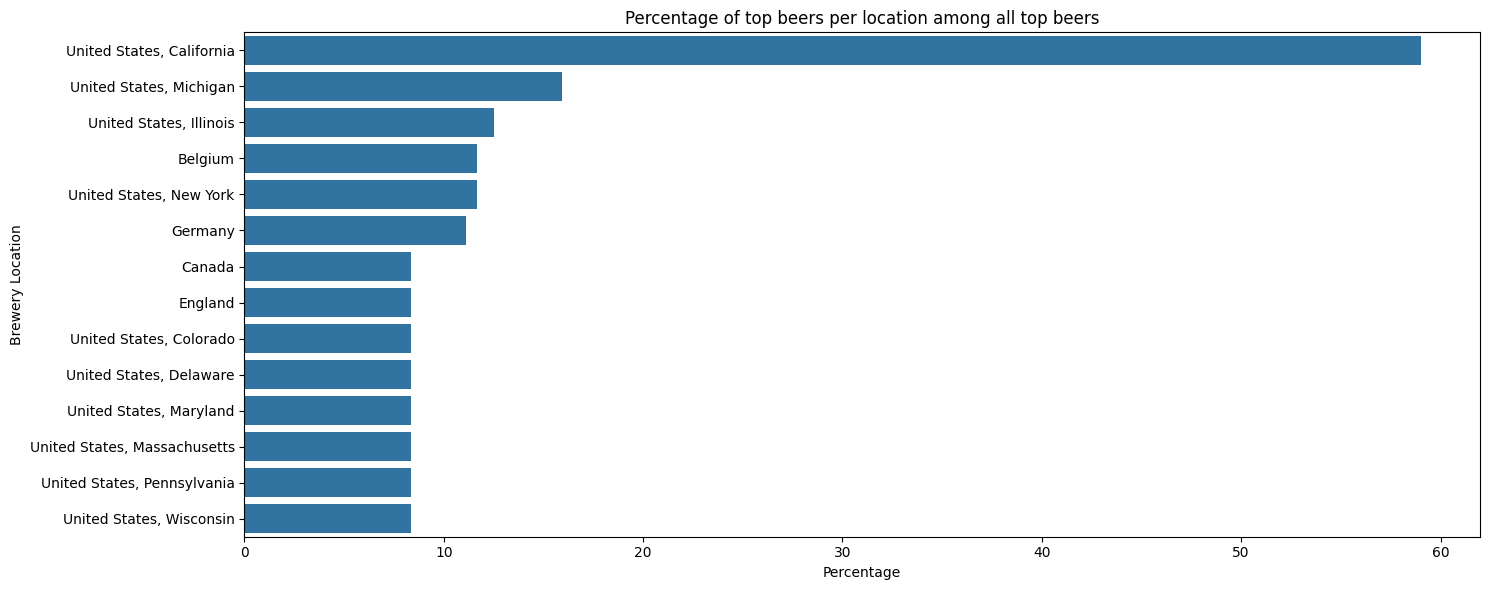

In [83]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
sns.barplot(x='percentage', y='brewery_location', data=locationAVG_df)

# Set the labels and title
plt.xlabel('Percentage')
plt.ylabel('Brewery Location')
plt.title('Percentage of top beers per location among all top beers in the years 2005-2016')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Is there a single month for which the location of the brewery of the average top beer for that month does not come from the US? Lets find out.

In [84]:
singleLocationMonthCUT_df = ratings_MonthLocationCUT_df.copy()

# sort by month and count
singleLocationMonthCUT_df = singleLocationMonthCUT_df.sort_values(by=['month', 'count'], ascending=[True, False])

# group by month and take first instance of each group
singleLocationMonthCUT_df = singleLocationMonthCUT_df.groupby('month').first().reset_index()

# display all locations which dont start with United States
print('There is a month for which the most top beers for that month come from a brewery outside the US: {}'.format(not(singleLocationMonthCUT_df[~singleLocationMonthCUT_df['brewery_location'].str.startswith('United States')].empty)))

There is a month for which the most top beers for that month come from a brewery outside the US: False


By the two plots above it becomes obvious that it is most frequently the US, that is home to the breweries which produce the top beer of the month. How does this relate to the fact that we only chose reviews by users located in the US? One could assume that they would be more likely to review or even favor beers by US breweries. Lets see if the location of the brewery has a significant impact on the rating by performing an observational study.

## Observational Study

The idea is to balance the covariates by calculating the propensity score of each review, using all covariates except for the rating and the location of the brewery corresponding to the beer reviewed. Reviews with similar propensity scores are then matched between the groups of beers produced by breweries within the US to those produced by breweries outside the US in order to determine if any statistically significance can be attributed to the location of the brewery being in the US.

In [85]:
ratings_combinedLOCATION_df.columns

Index(['beer_name', 'beer_id', 'brewery_id', 'brewery_name', 'style', 'date',
       'user_id', 'user_name', 'appearance', 'aroma', 'palate', 'taste',
       'overall', 'rating', 'text', 'year', 'month', 'year_month',
       'new_id_beer', 'new_id_brewery', 'abv', 'brewery_location', 'dataset',
       'good_review'],
      dtype='object')

Covariates that should be matched / included to calculate the propensity score:
- style
- month
- abv
- dataset

Since the dataset is very bulky, the size is reduced by only considering reviews from 2005 to 2016 and only sampling 5%

In [109]:
ratings_obsStudy_df = ratings_combinedLOCATION_df.copy()
ratings_obsStudy_df.drop(columns=['beer_id', 'brewery_id', 'date', 'user_id', 'user_name', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'text', 'year_month', 'new_id_brewery'], inplace=True)
# only keep ratings from 2005 to 2016
ratings_obsStudy_df = ratings_obsStudy_df[ratings_obsStudy_df['year'] >= 2005]
ratings_obsStudy_df = ratings_obsStudy_df[ratings_obsStudy_df['year'] <= 2016]
# only keep 10% of the ratings
print('Number of ratings before sampling:', ratings_obsStudy_df.shape[0])
ratings_obsStudy_df = ratings_obsStudy_df.sample(frac=0.05, random_state=42)
print('Number of ratings after sampling:', ratings_obsStudy_df.shape[0])
# create a column US_location which is True if the location is in the US and False otherwise
ratings_obsStudy_df['US_location'] = ratings_obsStudy_df['brewery_location'].str.startswith('United States')
ratings_obsStudy_df.head()

Number of ratings before sampling: 4865783
Number of ratings after sampling: 243289


,beer_name,brewery_name,style,rating,year,month,new_id_beer,abv,brewery_location,dataset,good_review,US_location
2069848,Old Brewery Pale Ale,Nelson Brewing Company,American Pale Ale (APA),0.750000,2006,3,8ba62e541bfd02554ca92dd676631f3eb1e77e1d04b0dd...,5.0,Canada,BeerAdvocate,True,False
1242690,Blue Point Summer Ale,Blue Point Brewing Company,American Blonde Ale,0.595000,2012,8,3f0b384f1a9898fade56a5834c1d1ec89c6a5b7ed2bff4...,4.4,"United States, New York",BeerAdvocate,False,True
2983104,Hi-Wire Strongman Coffee Milk Stout,Hi-Wire Brewing,Stout,0.711111,2016,1,a749b00ea9be669746da99fee715a6b86a8fe68d0469e4...,5.3,"United States, North Carolina",RateBeer,True,True
3173239,Southampton Imperial Russian Stout,Southampton Publick House,Imperial Stout,0.866667,2009,12,dcb8dc709f06861db18ceeb67be1d483fbe1cb153a8fcf...,10.5,"United States, New York",RateBeer,True,True
1397475,Weihenstephaner Festbier,Bayerische Staatsbrauerei Weihenstephan,Märzen / Oktoberfest,0.812500,2014,8,ded6287856a95f137de1963dffad847e42c775b781c1c6...,5.8,Germany,BeerAdvocate,True,False


Next we would have liked to perform a logistic regression to get the propensity score of each entry. For this we would have fit a model taking the variables declared above to the variable US_location, which indicates if a beer is coming from a brewery within the US. However this approach is not feasible as it is computationally too intense and crashes the kernel.

In [110]:
# import statsmodels.formula.api as smf

# mod = smf.logit(formula='US_location ~ style + year + month + abv + dataset', data=ratings_obsStudy_df)
# res = mod.fit()

# Adding the propensity score to the dataframe
# atings_obsStudy_df['propensity_score'] = res.predict(ratings_obsStudy_df)

Instead we now opt for Stratification to obtain the propensity scores.  
In our case it is done as follows:
- Divide your dataset into strata based on relevant covariates:
    - Style
    - Alcohol Content (abv, binned otherwise too many strata --> overfitting)
    - Month
    - Dataset
- Within each stratum, calculate the proportion of US and non-US beers.
- Assign each review a propensity score based on the proportion of reviews of US beers in its stratum.

In [111]:
# ratings_obsStudy_df['strata'] = pd.qcut(ratings_obsStudy_df['propensity_score'], 10)

# create a column abv_bin which maps the continuous values of abv to bins of size 2
ratings_obsStudy_df['abv_bin'] = pd.cut(ratings_obsStudy_df['abv'], bins=np.arange(0, 100, 2))

# Create a new column 'strata' that combines 'style', 'abv', 'year', 'month' and 'dataset'
ratings_obsStudy_df['strata'] = ratings_obsStudy_df['style'].astype(str) + '_' + \
                                ratings_obsStudy_df['abv_bin'].astype(str) + '_' + \
                                ratings_obsStudy_df['month'].astype(str) + '_' + \
                                ratings_obsStudy_df['dataset'].astype(str)

In [112]:
ratings_obsStudy_df[ratings_obsStudy_df['abv'] >= 20].head()

,beer_name,brewery_name,style,rating,year,month,new_id_beer,abv,brewery_location,dataset,good_review,US_location,abv_bin,strata
208541,Tactical Nuclear Penguin,BrewDog,American Double / Imperial Stout,0.600000,2010,9,d102ce0ce93e70fb0ad19ecbd90ab70d4776ce0a0c3dcf...,32.00,Scotland,BeerAdvocate,False,False,"(30, 32]","American Double / Imperial Stout_(30, 32]_9_Be..."
981304,Samuel Adams Utopias,Boston Beer Company (Samuel Adams),American Strong Ale,1.000000,2016,11,f9afe142f75bb813750ea3e52f1274b87451b2cf6de7d1...,29.00,"United States, Massachusetts",BeerAdvocate,True,True,"(28, 30]","American Strong Ale_(28, 30]_11_BeerAdvocate"
3196309,DuClaw Colossus (2006 & 2011),DuClaw Brewing Company,American Strong Ale,0.711111,2009,8,bfe604486e53599f5fe1d67fd725f99d11adcaeaf1788c...,21.92,"United States, Maryland",RateBeer,True,True,"(20, 22]","American Strong Ale_(20, 22]_8_RateBeer"
1528407,Samuel Adams Utopias,Boston Beer Company (Samuel Adams),American Strong Ale,0.707500,2011,12,f9afe142f75bb813750ea3e52f1274b87451b2cf6de7d1...,29.00,"United States, Massachusetts",BeerAdvocate,False,True,"(28, 30]","American Strong Ale_(28, 30]_12_BeerAdvocate"
554103,Samuel Adams Utopias,Boston Beer Company (Samuel Adams),American Strong Ale,0.807500,2012,12,f9afe142f75bb813750ea3e52f1274b87451b2cf6de7d1...,29.00,"United States, Massachusetts",BeerAdvocate,True,True,"(28, 30]","American Strong Ale_(28, 30]_12_BeerAdvocate"


Assign to each strata a propensity score based on the fraction of review of beers that are from the US. This fraction equals the mean of the US_location column as it consists of booleans (0s or 1s).

In [113]:
ratings_obsStudy_df['propensity_score'] = ratings_obsStudy_df.groupby('strata')['US_location'].transform('mean')
ratings_obsStudy_df.head()

,beer_name,brewery_name,style,rating,year,month,new_id_beer,abv,brewery_location,dataset,good_review,US_location,abv_bin,strata,propensity_score
2069848,Old Brewery Pale Ale,Nelson Brewing Company,American Pale Ale (APA),0.750000,2006,3,8ba62e541bfd02554ca92dd676631f3eb1e77e1d04b0dd...,5.0,Canada,BeerAdvocate,True,False,"(4, 6]","American Pale Ale (APA)_(4, 6]_3_BeerAdvocate",0.974729
1242690,Blue Point Summer Ale,Blue Point Brewing Company,American Blonde Ale,0.595000,2012,8,3f0b384f1a9898fade56a5834c1d1ec89c6a5b7ed2bff4...,4.4,"United States, New York",BeerAdvocate,False,True,"(4, 6]","American Blonde Ale_(4, 6]_8_BeerAdvocate",0.927536
2983104,Hi-Wire Strongman Coffee Milk Stout,Hi-Wire Brewing,Stout,0.711111,2016,1,a749b00ea9be669746da99fee715a6b86a8fe68d0469e4...,5.3,"United States, North Carolina",RateBeer,True,True,"(4, 6]","Stout_(4, 6]_1_RateBeer",0.739130
3173239,Southampton Imperial Russian Stout,Southampton Publick House,Imperial Stout,0.866667,2009,12,dcb8dc709f06861db18ceeb67be1d483fbe1cb153a8fcf...,10.5,"United States, New York",RateBeer,True,True,"(10, 12]","Imperial Stout_(10, 12]_12_RateBeer",0.859223
1397475,Weihenstephaner Festbier,Bayerische Staatsbrauerei Weihenstephan,Märzen / Oktoberfest,0.812500,2014,8,ded6287856a95f137de1963dffad847e42c775b781c1c6...,5.8,Germany,BeerAdvocate,True,False,"(4, 6]","Märzen / Oktoberfest_(4, 6]_8_BeerAdvocate",0.826923


In [114]:
# maybe the kernel wont crash if we bin the propensity scores in bins of size 0.05
ratings_obsStudy_df['propensity_score_bin'] = pd.cut(ratings_obsStudy_df['propensity_score'], bins=np.arange(0, 1.05, 0.05))
# set the propensity score bins to the upper bound of the bin
ratings_obsStudy_df['propensity_score_bin'] = ratings_obsStudy_df['propensity_score_bin'].apply(lambda x: x.right)

In [115]:
ratings_obsStudy_df.head()

,beer_name,brewery_name,style,rating,year,month,new_id_beer,abv,brewery_location,dataset,good_review,US_location,abv_bin,strata,propensity_score,propensity_score_bin
2069848,Old Brewery Pale Ale,Nelson Brewing Company,American Pale Ale (APA),0.750000,2006,3,8ba62e541bfd02554ca92dd676631f3eb1e77e1d04b0dd...,5.0,Canada,BeerAdvocate,True,False,"(4, 6]","American Pale Ale (APA)_(4, 6]_3_BeerAdvocate",0.974729,1.00
1242690,Blue Point Summer Ale,Blue Point Brewing Company,American Blonde Ale,0.595000,2012,8,3f0b384f1a9898fade56a5834c1d1ec89c6a5b7ed2bff4...,4.4,"United States, New York",BeerAdvocate,False,True,"(4, 6]","American Blonde Ale_(4, 6]_8_BeerAdvocate",0.927536,0.95
2983104,Hi-Wire Strongman Coffee Milk Stout,Hi-Wire Brewing,Stout,0.711111,2016,1,a749b00ea9be669746da99fee715a6b86a8fe68d0469e4...,5.3,"United States, North Carolina",RateBeer,True,True,"(4, 6]","Stout_(4, 6]_1_RateBeer",0.739130,0.75
3173239,Southampton Imperial Russian Stout,Southampton Publick House,Imperial Stout,0.866667,2009,12,dcb8dc709f06861db18ceeb67be1d483fbe1cb153a8fcf...,10.5,"United States, New York",RateBeer,True,True,"(10, 12]","Imperial Stout_(10, 12]_12_RateBeer",0.859223,0.90
1397475,Weihenstephaner Festbier,Bayerische Staatsbrauerei Weihenstephan,Märzen / Oktoberfest,0.812500,2014,8,ded6287856a95f137de1963dffad847e42c775b781c1c6...,5.8,Germany,BeerAdvocate,True,False,"(4, 6]","Märzen / Oktoberfest_(4, 6]_8_BeerAdvocate",0.826923,0.85


Now, let's create a function to compute similarity, based on propensity score. To do this, we want to minimize the difference between propensity scores according to the following formula:

$$similarity(propensity\_score1, propensity\_score2) = 1 - |propensity\_score1 - propensity\_score2|$$



In [128]:
def get_similarity(propensity_score1, propensity_score2):
    return 1 - np.abs(propensity_score1 - propensity_score2)

We now separate treatment and control group.

In [129]:
treatment_group = ratings_obsStudy_df[ratings_obsStudy_df['US_location'] == True]
control_group = ratings_obsStudy_df[ratings_obsStudy_df['US_location'] == False]

Now, we loop over all possible pairs (treatment, control) and compute their similarity, based on the propensity score. We will represent it with a Graph. Each treatment node is linked to a control node with an edge which weight is the similarity between the nodes.

Let's create the Graph.

In [130]:
# import networkx as nx

G = nx.Graph()

In [131]:
# for control_id, control_row in control_group.iterrows():
#     for treatment_id, treatment_row in treatment_group.iterrows():

#         # compute the similarity between the control and treatement instances.
#         similarity = get_similarity(treatment_row['propensity_score'], control_row['propensity_score'])

#         # We add an edge between control and treatment instance, weighted by their similarity
#         G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

In [142]:
# potentially optimized version of the above code

# control_scores and treatment_scores need to be of the same size
if len(control_group) > len(treatment_group):
    control_scores = control_group.sample(n=len(treatment_group), random_state=42)
    control_scores = control_scores['propensity_score'].values
    treatment_scores = treatment_group['propensity_score'].values
    print('control_scores is bigger')
if len(control_group) < len(treatment_group):
    treatment_scores = treatment_group.sample(n=len(control_group), random_state=42)
    treatment_scores = treatment_scores['propensity_score'].values
    control_scores = control_group['propensity_score'].values

similarities = get_similarity(treatment_scores, control_scores)

G.add_weighted_edges_from(zip(control_group.index, treatment_group.index, similarities))

Let's now compute the matching.

In [143]:
matching = list(nx.max_weight_matching(G))

# all reviews that have a 'match'
matched_reviews = ([m[0] for m in matching] + [m[1] for m in matching])

# dataframe of matched reviews only
matched_df = (ratings_obsStudy_df.loc[matched_reviews]).sort_index()

display(matched_df)

In [ ]:
# calculate the linear regression of "good_review ~ US_location"
mod = smf.ols(formula='good_review ~ US_location', data=matched_df)
res = mod.fit()
print(f"Model Summary: \n {mod.summary()} \n")
print(f'p-value: {res.pvalues["US_location"]:.3f}')
print(f'Reject null hypothesis (alpha = 0.05): {res.pvalues["US_location"] < 0.05}')

# whoopwhooop

For the dataframe that also groups the years together we rank according to month, highest average_rating and good_review_count

In [85]:
# rank dataframe
ratings_mergeBeerMonth_df = ratings_mergeBeerMonth_df.sort_values(by=['month', 'good_review_count', 'average_rating'], ascending=[True, False, False])

ratings_rankBeerMonth_df = ratings_mergeBeerMonth_df.copy()

# to obtain the top beer for each month, group by month and take the first instance of each month
ratings_rankBeerMonth_df = ratings_rankBeerMonth_df.groupby('month').first().reset_index()

List the location for each month

In [86]:
# list the location for each month
for month in range(1, 13):
    print('Month:', month)
    print(ratings_rankBeerMonth_df[ratings_rankBeerMonth_df['month'] == month][['brewery_location']])

Month: 1
          brewery_location
0  United States, Michigan
Month: 2
          brewery_location
1  United States, Michigan
Month: 3
              brewery_location
2  United States, Pennsylvania
Month: 4
          brewery_location
3  United States, Michigan
Month: 5
            brewery_location
4  United States, California
Month: 6
            brewery_location
5  United States, California
Month: 7
            brewery_location
6  United States, California
Month: 8
            brewery_location
7  United States, California
Month: 9
  brewery_location
8          Germany
Month: 10
          brewery_location
9  United States, Michigan
Month: 11
             brewery_location
10  United States, California
Month: 12
             brewery_location
11  United States, California


Plot the locations of the top beers for each month.

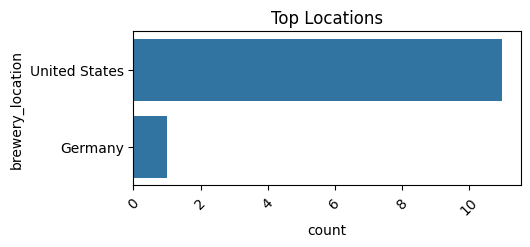

In [87]:
# to group all states in the US together only take the first part of the location
shortened_top_locations = ratings_rankBeerMonth_df['brewery_location'].str.split(',').str[0]

# plot the top locations
plt.figure(figsize=(5, 2))
sns.countplot(shortened_top_locations, order=shortened_top_locations.value_counts().index)
plt.title('Top Locations')
plt.xticks(rotation=45)
plt.show()

In [88]:
# show the month for which the top beer is from germany
display(ratings_rankBeerMonth_df[ratings_rankBeerMonth_df['brewery_location'] == 'Germany'])

,month,beer_name,brewery_name,brewery_location,style,average_rating,total_ratings,good_review_count,new_id_beer
8,9,Ayinger Oktober Fest-Märzen,Brauerei Aying,Germany,Oktoberfest/Märzen,0.720714,719,542,ac9e4412a97b0b8229323576abe8caa82f12959bebc0a9...


The top beer for the month of September is an Oktoberfest-style beer while this is not the case for the month of October. Interestingly the bigger part of Oktoberfest actually happens during September and not October, which might explain this fact. Also the assumption can be made that Oktoberfest-style beers are reviewed in the events building up to the Oktoberfest rather than after the Oktoberfest as the information that can be gained from such a review can be seen as most valuable right before the event.